# From Reports to Gaps

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker
import pandas as pd
import geopandas as gpd
import movingpandas as mpd
import dataframe_image as dfi
import contextily as cx
import shapely as sh
from geopy.distance import geodesic
from utils import getValues, DATASETS_DIRECTORY_PATH

In [2]:
static = pd.read_csv(f'{DATASETS_DIRECTORY_PATH}static.csv', parse_dates=['timestamp'])
dynamic = pd.read_csv(f'{DATASETS_DIRECTORY_PATH}dynamic.csv', parse_dates=['timestamp'])
dynamic['geometry'] = gpd.GeoSeries.from_wkt(dynamic['geometry'], crs='EPSG:4326')
dynamic = gpd.GeoDataFrame(dynamic)

C:\Users\baudo\AppData\Local\Temp\ipykernel_34716\3960310851.py:1: DtypeWarning: Columns (9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  static = pd.read_csv(f'{DATASETS_DIRECTORY_PATH}static.csv', parse_dates=['timestamp'])


In [3]:
cutoff = 100 #mmsi which occur this amount of time or less are discarded
keptMMSI = [k[0] for k in getValues(dynamic.sourcemmsi).items() if k[1] > cutoff]
discardedMMSI = [k[0] for k in getValues(dynamic.sourcemmsi).items() if k[1] <= cutoff] #will be used later on
trajectories = pd.DataFrame({'mmsi': keptMMSI})

def getTrajectory(mmsi):
    trajectory = dynamic.loc[dynamic.sourcemmsi == mmsi]
    trajectory['dynamic_id'] = trajectory.index
    trajectory = trajectory.drop('sourcemmsi', axis=1)
    trajectory.index = pd.DatetimeIndex(trajectory.timestamp)
    trajectory = mpd.Trajectory(trajectory, mmsi)
    trajectory.add_timedelta()
    return trajectory


import warnings
warnings.filterwarnings("ignore")
trajectories['trajectory'] = trajectories.mmsi.apply(getTrajectory)

In [4]:
print(f'{len(keptMMSI)} MMSI kept and {len(discardedMMSI)} MMSI discarded')
print(f'among the original {len(getValues(dynamic.sourcemmsi))} MMSI numbers.')

269 MMSI kept and 75 MMSI discarded
among the original 344 MMSI numbers.


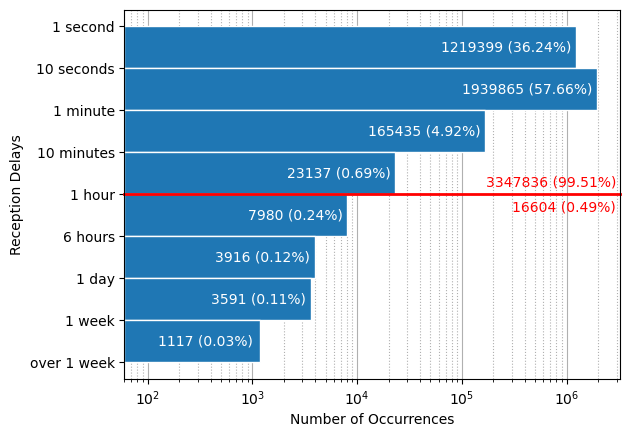

In [5]:
get_td = lambda k: trajectories.trajectory.loc[k].df.timedelta.dt.total_seconds()
td = np.hstack([get_td(k).to_numpy() for k in trajectories.index])
td = np.nan_to_num(td)

bins = [1, 10, 60, 600, 3600, 6*3600, 24*3600, 7*24*3600, td.max()]
binLabels = ['1 second', '10 seconds', '1 minute', '10 minutes',
             '1 hour', '6 hours', '1 day', '1 week', 'over 1 week']

fig, ax = plt.subplots()
X, _ = np.histogram(td, bins=bins)
Y = np.arange(len(X))
ax.barh(Y, X, height=1, align='edge', left=60, log=True, zorder=2, edgecolor='w')
ax.set_xlabel('Number of Occurrences')
ax.set_ylabel('Reception Delays')
ax.invert_yaxis()
ax.set_yticks(np.arange(len(X) + 1), binLabels)
ax.grid(axis='x')
ax.grid(which='minor', ls=':', axis='x')
for i in range(len(X)):
    percent = np.round(X[i] / np.sum(X) * 100, 2)
    ax.text(X[i], Y[i]+0.5, f'{X[i]} ({percent}%) ',
            va='center', ha='right', color='w')

threshold = 4 #cut between nth and n+1th bar, counting downward
drop = np.sum(X[:threshold])
keep = np.sum(X[threshold:])
dpercent = np.round(drop / np.sum(X) * 100, 2)
kpercent = np.round(keep / np.sum(X) * 100, 2)
kwargs1 = {'color':'r', 'clip_on':False, 'transform':ax.get_yaxis_transform()}
kwargs2 = {'va':'center', 'ha':'right'}
ax.plot([0, 1], [threshold, threshold], lw=2, **kwargs1)
ax.text(1, threshold-0.3, f'{drop} ({dpercent}%) ', **kwargs1, **kwargs2)
ax.text(1, threshold+0.3, f'{keep} ({kpercent}%) ', **kwargs1, **kwargs2)

cutoff = bins[threshold]

In [6]:
%%time
gaps = []

def getGap(df, i):
    gap = {'mmsi': df.iloc[i].traj_id,
           'disappearid': df.iloc[i-1].dynamic_id,
           'disappeartime': df.iloc[i-1].timestamp,
           'disappearlocation': df.iloc[i-1].geometry,
           'reappearid': df.iloc[i].dynamic_id,
           'reappeartime': df.iloc[i].timestamp,
           'reappearlocation': df.iloc[i].geometry}
    gaps.append(gap)

def locateGaps(trajectory):
    timestamps = trajectory.df.loc[trajectory.df.timedelta.dt.total_seconds() >= cutoff].index
    indices = [trajectory.df.index.get_loc(ts) for ts in timestamps]
    for i in indices:
        getGap(trajectory.df, i)

trajectories.trajectory.apply(locateGaps)

gaps = pd.DataFrame(gaps)

CPU times: total: 5.33 s
Wall time: 8.43 s


In [7]:
getline = lambda gap: sh.geometry.LineString([gap.disappearlocation, gap.reappearlocation])
gaps['geometry'] = gaps.apply(getline, axis=1)
gaps = gpd.GeoDataFrame(gaps, geometry=gaps.geometry, crs='EPSG:4326')
gaps['darkduration'] = (gaps.reappeartime - gaps.disappeartime).dt.total_seconds()
lonlat = lambda point: (point.x, point.y)
dist = lambda A, B: geodesic(lonlat(A), lonlat(B)).nm
getdist = lambda gap: dist(gap.disappearlocation, gap.reappearlocation)
gaps['darkdistance'] = gaps.apply(getdist, axis=1)
gaps['darkspeed'] = gaps.darkdistance / (gaps.darkduration / 3600)

In [14]:
dfi.export(gaps.head(), 'Figures/gaps_header.png', dpi=200)
gaps.head()

mmsi  disappearid       disappeartime             disappearlocation  \
0  228336000        23914 2015-10-02 03:29:19   POINT (-4.747795 48.185574)   
1  228336000        38897 2015-10-03 09:48:27   POINT (-5.1333485 48.16744)   
2  228336000        42832 2015-10-03 15:38:34  POINT (-5.1665335 48.598743)   
3  228336000        43161 2015-10-03 18:33:45  POINT (-4.7796965 48.360165)   
4  228336000        53273 2015-10-05 08:38:37    POINT (-4.7800317 48.3596)   

   reappearid        reappeartime              reappearlocation  \
0       36073 2015-10-03 04:33:14   POINT (-4.7795234 48.36025)   
1       42831 2015-10-03 15:38:24  POINT (-5.1669436 48.598495)   
2       42886 2015-10-03 17:32:43    POINT (-4.907183 48.45989)   
3       49482 2015-10-05 00:43:11  POINT (-4.7795634 48.360226)   
4       64511 2015-10-06 00:38:49   POINT (-4.779775 48.360493)   

                                            geometry  darkduration  \
0  LINESTRING (-4.74779 48.18557, -4.77952 48.36025)       90235.0   
1  LINESTRING (-5.13335 48.16744, -5.16694 48.59849)       20997.0   
2  LINESTRING (-5.16653 48.59874, -4.90718 48.45989)        6849.0   
3  LINESTRING (-4.77970 48.36017, -4.77956 48.36023)      108566.0   
4  LINESTRING (-4.78003 48.35960, -4.77977 48.36049)       57612.0   

   darkdistance  darkspeed  
0     10.633473   0.424231  
1     25.883674   4.437835  
2     17.576539   9.238654  
3      0.008747   0.000290  
4      0.055643   0.003477

In order to make a distinction between gap edges and "normal" reports, the following code adds a flag directly to every report from `dynamic` indicating whether that report is normal (`'none'`), the beginning of a gap (`'disappear'`), the end of a gap (`'reappear'`) or a report surrounded by two gaps (`'lone'`). It also flags as `sparse` every report from a discarded MMSI.

This will be useful for both plotting and feature computation later on. 

In [9]:
dynamic['edge'] = ['none']*len(dynamic)
def flagReappear(dynamic_id):
    dynamic.at[dynamic_id, 'edge'] = 'reappear'
def flagDisappear(dynamic_id):
    if dynamic.at[dynamic_id, 'edge'] == 'none':
        dynamic.at[dynamic_id, 'edge'] = 'disappear'
    else:
        dynamic.at[dynamic_id, 'edge'] = 'lone'
gaps.reappearid.apply(flagReappear)
gaps.disappearid.apply(flagDisappear)

dynamic.loc[dynamic.sourcemmsi.apply(lambda mmsi: mmsi in discardedMMSI), 'edge'] = 'sparse'

getValues(dynamic.edge)

{'none': 3338883,
 'disappear': 10921,
 'reappear': 10921,
 'lone': 5683,
 'sparse': 2503}

In [10]:
gaps[['mmsi', 'darkdistance', 'darkspeed', 'geometry']].explore(column='darkspeed')

In [11]:
edges = pd.concat([gaps.disappearlocation, gaps.reappearlocation], keys=['disappear', 'reappear'], names=['edge', 'gap_id'])
edges = pd.DataFrame({'geometry': edges})
edges = gpd.GeoDataFrame(edges, geometry=edges.geometry, crs='EPSG:4326')
edges = edges.reset_index()
edges

edge  gap_id                   geometry
0      disappear       0  POINT (-4.74779 48.18557)
1      disappear       1  POINT (-5.13335 48.16744)
2      disappear       2  POINT (-5.16653 48.59874)
3      disappear       3  POINT (-4.77970 48.36017)
4      disappear       4  POINT (-4.78003 48.35960)
...          ...     ...                        ...
33203   reappear   16599  POINT (-2.01415 48.72191)
33204   reappear   16600  POINT (-2.04136 48.64564)
33205   reappear   16601  POINT (-2.22509 48.71876)
33206   reappear   16602  POINT (-2.05011 48.65127)
33207   reappear   16603  POINT (-2.09113 48.67605)

[33208 rows x 3 columns]

In [12]:
gaps.to_csv(f'{DATASETS_DIRECTORY_PATH}gaps.csv', index=False)
edges.to_csv(f'{DATASETS_DIRECTORY_PATH}edges.csv', index=False)
dynamic.to_csv(f'{DATASETS_DIRECTORY_PATH}dynamic.csv', index=False)